# Spectral Analysis Project

The aim of this project is to explore how information from galactic spectra can be extracted using machine learning and how it can determine important physical quantities.


In [2]:
# Importing libraries
# Basics 
import pandas as pd
import numpy as np
from scipy import stats

# Visualizaton 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# ML
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## EDA - Exploratory data analysis 

### The dataset 

Downolading the raw dataset I created and downloaded with the CasJobs interface as a csv file. 
The dataset is not filtered and cleaned, and so we proceed with the cleaning and the EDA.

The dataset is the result of the merging of SpecObj and PhotoObj tables on the same attribute (specObjID) : 
- PhotoObj contains Photometric data
- SpecObj contains spectroscopic data

In [3]:
# Converting the csv into a pandas dataframe 
raw_df = pd.read_csv('/Users/emmatosato/Documents/UNI/Erasmus/Data Mining and Machine Learning/Spectral-AnalysisProject/SDSS_dataset.csv')

### Raw dataset insights

In [4]:
raw_df.shape

(10000, 704)

In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 704 entries, objID to img
dtypes: float64(557), int64(132), object(15)
memory usage: 53.7+ MB


In [6]:
raw_df.head(100)

,objID,skyVersion,run,rerun,camcol,field,obj,mode,nChild,type,...,elodieLogG,elodieFeH,elodieZ,elodieZErr,elodieZModelErr,elodieRChi2,elodieDOF,Column9,Column10,img
0,1237674650460684416,2,6793,301,4,55,128,1,0,6,...,4.49,-1.7,0.000024,0.000008,0.000002,0.889679,2137,15401755927646,5067,System.Byte[]
1,1237674650460684446,2,6793,301,4,55,158,1,0,3,...,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0,15449011177454,5067,System.Byte[]
2,1237674650460684511,2,6793,301,4,55,223,1,0,3,...,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0,15448999163844,5067,System.Byte[]
3,1237674650460684544,2,6793,301,4,55,256,1,0,3,...,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0,15401755241894,5067,System.Byte[]
4,1237674650460749979,2,6793,301,4,56,155,1,0,3,...,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0,15401766686400,5067,System.Byte[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1237648720141877432,2,756,301,1,198,184,1,0,3,...,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0,10522837970854,5067,System.Byte[]
96,1237648720141877472,2,756,301,1,198,224,1,0,3,...,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0,10523572792087,5067,System.Byte[]
97,1237648720141943039,2,756,301,1,199,255,1,0,3,...,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0,10522853496825,5067,System.Byte[]
98,1237648720141943050,2,756,301,1,199,266,1,0,3,...,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0,10522845005953,5067,System.Byte[]


In [7]:
raw_df.tail(10)

,objID,skyVersion,run,rerun,camcol,field,obj,mode,nChild,type,...,elodieLogG,elodieFeH,elodieZ,elodieZErr,elodieZModelErr,elodieRChi2,elodieDOF,Column9,Column10,img
9990,1237674650460356844,2,6793,301,4,50,236,1,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0,15431855202684,5067,System.Byte[]
9991,1237674650460553274,2,6793,301,4,53,58,1,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0,15431826462671,5067,System.Byte[]
9992,1237674650460422277,2,6793,301,4,51,133,1,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0,15431857736234,5067,System.Byte[]
9993,1237674650460553318,2,6793,301,4,53,102,1,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0,15431881131486,5067,System.Byte[]
9994,1237674650460750003,2,6793,301,4,56,179,1,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0,15401768998482,5067,System.Byte[]
9995,1237674650460422444,2,6793,301,4,51,300,1,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0,15431865054797,5067,System.Byte[]
9996,1237674650460553354,2,6793,301,4,53,138,1,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0,15431827378494,5067,System.Byte[]
9997,1237674650460553364,2,6793,301,4,53,148,1,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0,15431830114914,5067,System.Byte[]
9998,1237674650460553396,2,6793,301,4,53,180,1,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0,15431827585021,5067,System.Byte[]
9999,1237674650460618904,2,6793,301,4,54,152,1,0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0,15448997512553,5067,System.Byte[]


### Null values 

In [8]:
# Check the NaN values in the datset
v = raw_df.isnull().sum()

# Mask for finding the non zero values in the v vector crated (so the columns which contain NaN values)
non_zero_mask = [value != 0 for value in v]
v[non_zero_mask]

run1d              10000
subClass            5299
class_noqso        10000
subClass_noqso     10000
comments_person    10000
tFile                 11
elodieFileName      9138
elodieObject        9138
elodieSpType        9138
dtype: int64

I will drop the run1d, class_noqso, subClass_noqso and comments_person because all the rows are NaN values. I will delete also the subClass, elodieFileName, elodieObject and elodieSpType because the contain too many null values too.

The tFile attribute has only 11 NaN values, so i will directly drop the 11 rows that have this attribute null instead of imputing the missing values (tFile is a column which contains the *"File name of best fit template source"*). Since i have a large dataset, this action should not influence the analysis.

In [9]:
# Dropping the columns
df = raw_df.copy()
df.drop(columns=['run1d', 'subClass', 'class_noqso', 'subClass_noqso', 'comments_person', 'elodieFileName', 'elodieObject', 'elodieSpType'], inplace = True)

In [10]:
# Dropping the rows
df.dropna(inplace= True)

In [11]:
# Cheking if everthing worked well
v = df.isnull().sum()
non_zero_mask = [value != 0 for value in v]
v[non_zero_mask]

Series([], dtype: int64)

In [12]:
df.shape

(9989, 696)

### Duplicated rows

With this step, no duplicate rows should be found, because the dataset should already be full of unique objects.

In [13]:
df[df.duplicated() == True]

,objID,skyVersion,run,rerun,camcol,field,obj,mode,nChild,type,...,elodieLogG,elodieFeH,elodieZ,elodieZErr,elodieZModelErr,elodieRChi2,elodieDOF,Column9,Column10,img


### Data exploration

On the skyserver website it is possible to access to useful informations and explanations of the SDSS data. 
On this link you can find the description of all the columns of the dataset, both for SpecObj and PhotoObj tables, which I merged before the downolading : https://skyserver.sdss.org/dr18/MoreTools/browser

I will select a subset of columns i found relevant for data exploration.

#### Type attribute

In the table *PhotoObj* the **type** column is the: type classification of the object (star, galaxy, cosmic ray, etc.). This column typically provides the overall or general classification of an astronomical object based on its spectral characteristics and other properties.

In [14]:
df['type'].value_counts()

3    8613
6    1363
0      13
Name: type, dtype: int64

Type:
- 3 = Galaxy 
- 6 = Star
- 0 = Unknown

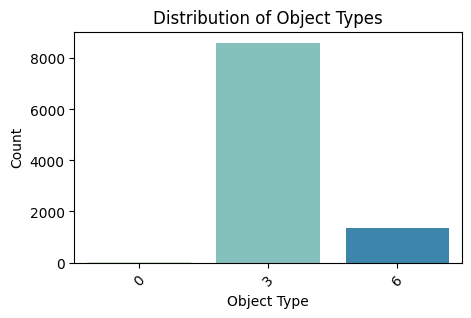

In [15]:
plt.figure(figsize=(5, 3))  # Optional: Adjust the figure size
sns.countplot(data=df, x='type', palette = 'GnBu')
plt.title("Distribution of Object Types")
plt.xlabel("Object Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In the table *PhotoObj* the **type_u** column is the: object type classification per band, which classificates based on observations made in specific wavelength bands. It should allow a more detailed analysis. Let's compare the 2 attributes.

In [16]:
# Concatenate the two Series into a DataFrame
types_df = pd.concat([df['type'].value_counts(), df['type_u'].value_counts()], axis=1)

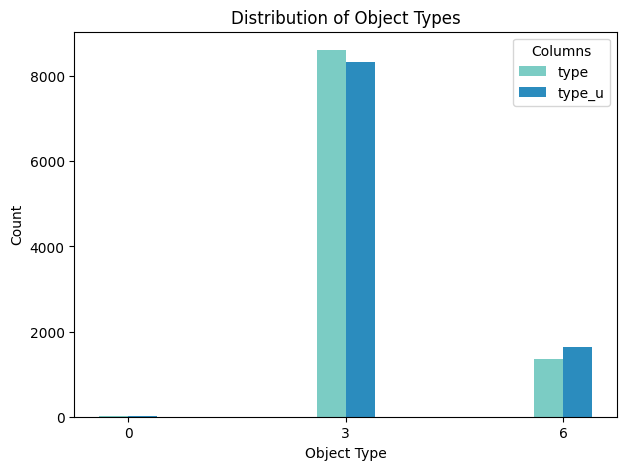

In [17]:
# Create a bar plot
plt.figure(figsize=(7, 5))

# Set the positions for the bars for 'type' and 'type_u'
bar_width = 0.4  # Width of each bar
index = types_df.index
index_type_u = [i + bar_width for i in index]

# Plot 'type' and 'type_u' counts side by side
plt.bar(index, types_df['type'], width=bar_width, color='#7bccc4', label='type')
plt.bar(index_type_u, types_df['type_u'], width=bar_width, color='#2b8cbe', label='type_u')

# Customize the plot
plt.title("Distribution of Object Types")
plt.xlabel("Object Type")
plt.ylabel("Count")
plt.legend(title="Columns")
plt.xticks(index + bar_width / 2, index)  # Position x-axis labels between bars

# Show the plot
plt.show()


We can see only a little difference.

In [18]:
'''
# Point 2: Magnitude Distributions
magnitude_cols = ['psfMag_u', 'petroMag_u', 'deVMag_u', 'expMag_u']
for col in magnitude_cols:
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.show()

# Point 3: Magnitude vs. Redshift
plt.scatter(df['z'], df['psfMag_u'], alpha=0.5)
plt.title("Redshift vs. PSF Magnitude")
plt.xlabel("Redshift (z)")
plt.ylabel("PSF Magnitude (psfMag_u)")
plt.show()

# Continue with the rest of the points (4-17) following similar patterns
# ...

# Point 8: Redshift vs. Reduced Chi-Squared
plt.scatter(df['z'], df['rChi2'], alpha=0.5)
plt.title("Redshift vs. Reduced Chi-Squared")
plt.xlabel("Redshift (z)")
plt.ylabel("Reduced Chi-Squared (rChi2)")
plt.show()

# Point 9: Redshift vs. Classification (z, class_noqso)
sns.countplot(data=df, x='z', hue='class_noqso')
plt.title("Classification vs. Redshift")
plt.xlabel("Redshift (z)")
plt.ylabel("Count")
plt.legend(title="Classification")
plt.show()

# Point 10: Pairwise Scatterplots (Subset of columns)
subset_cols = ['psfMag_u', 'petroMag_u', 'deVMag_u', 'expMag_u', 'z']
sns.pairplot(data=df[subset_cols])
plt.show()

# Point 12: Correlation Heatmap
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Point 16: Metallicity vs. Redshift
plt.scatter(df['z'], df['elodieFeH'], alpha=0.5)
plt.title("Metallicity vs. Redshift")
plt.xlabel("Redshift (z)")
plt.ylabel("Metallicity (elodieFeH)")
plt.show()

# Point 17: Redshift Error vs. Metallicity
plt.scatter(df['elodieFeH'], df['zErr'], alpha=0.5)
plt.title("Metallicity vs. Redshift Error")
plt.xlabel("Metallicity (elodieFeH)")
plt.ylabel("Redshift Error (zErr)")
plt.show()

'''

'\n# Point 2: Magnitude Distributions\nmagnitude_cols = [\'psfMag_u\', \'petroMag_u\', \'deVMag_u\', \'expMag_u\']\nfor col in magnitude_cols:\n    sns.histplot(data=df, x=col, kde=True)\n    plt.title(f"Distribution of {col}")\n    plt.xlabel(col)\n    plt.ylabel("Density")\n    plt.show()\n\n# Point 3: Magnitude vs. Redshift\nplt.scatter(df[\'z\'], df[\'psfMag_u\'], alpha=0.5)\nplt.title("Redshift vs. PSF Magnitude")\nplt.xlabel("Redshift (z)")\nplt.ylabel("PSF Magnitude (psfMag_u)")\nplt.show()\n\n# Continue with the rest of the points (4-17) following similar patterns\n# ...\n\n# Point 8: Redshift vs. Reduced Chi-Squared\nplt.scatter(df[\'z\'], df[\'rChi2\'], alpha=0.5)\nplt.title("Redshift vs. Reduced Chi-Squared")\nplt.xlabel("Redshift (z)")\nplt.ylabel("Reduced Chi-Squared (rChi2)")\nplt.show()\n\n# Point 9: Redshift vs. Classification (z, class_noqso)\nsns.countplot(data=df, x=\'z\', hue=\'class_noqso\')\nplt.title("Classification vs. Redshift")\nplt.xlabel("Redshift (z)")\nplt

#### Red shift attribute (z)

First, I will look for outliers.

In [92]:
# Calculate Z-scores on the 'z' column
z_scores = stats.zscore(df['z'])

# Identify outliers based on Z-scores
outliers = (z_scores > 3) | (z_scores < -3)

In [97]:
# Outliers
df[outliers == True]['z'].value_counts()

-9999.0    16
Name: z, dtype: int64

A redshift value of -9999 is typically used as sentinel value to indicate missing or undefined data in the context of astronomical observations.

When you encounter a redshift value of -9999, it generally means one of the following:
- Missing Data
- Placeholder Value
- Data Quality Flag

In summary, a redshift value of -9999 is not a valid redshift measurement but rather a way to handle missing or problematic data in astronomical datasets.

For these reasons, we delete the rows which contain this value for the redshift.

In [98]:
# Drop rows corresponding to outliers
df.drop(df[outliers].index, inplace=True)

# Reset the index of the DataFrame
df.reset_index(drop=True, inplace=True)

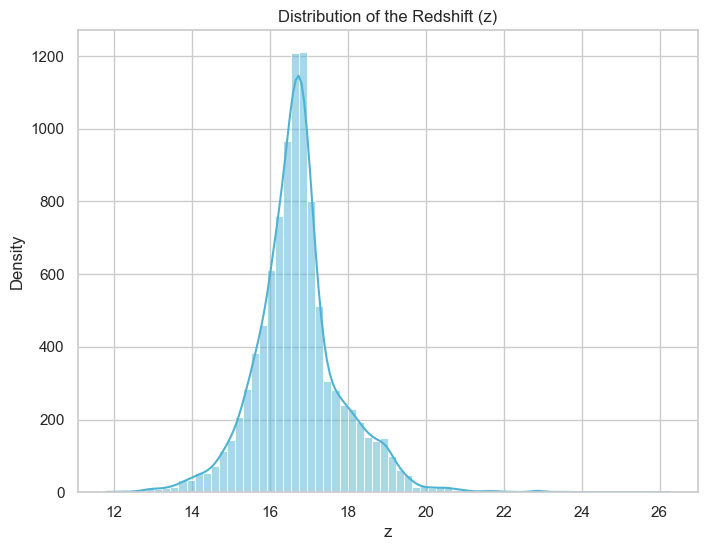

In [110]:
# Set Seaborn style
sns.set(style="whitegrid")

# Create a distribution plot using Seaborn
plt.figure(figsize=(8, 6))
sns.histplot(df['z'], bins=70, color = '#4eb3d3', kde=True)
plt.title("Distribution of the Redshift (z)")
plt.xlabel("z")
plt.ylabel("Density")
plt.show()

#### Magnitude attributes

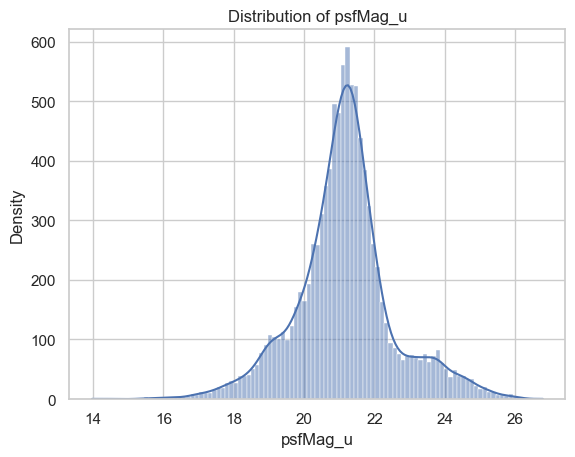

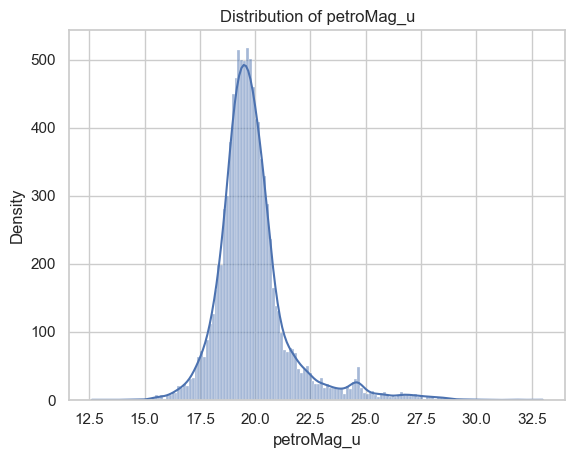

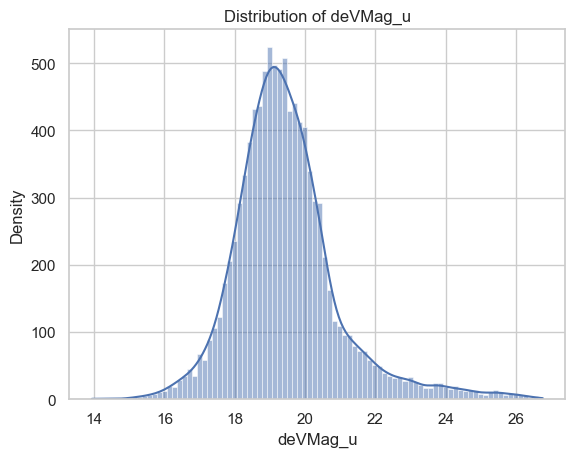

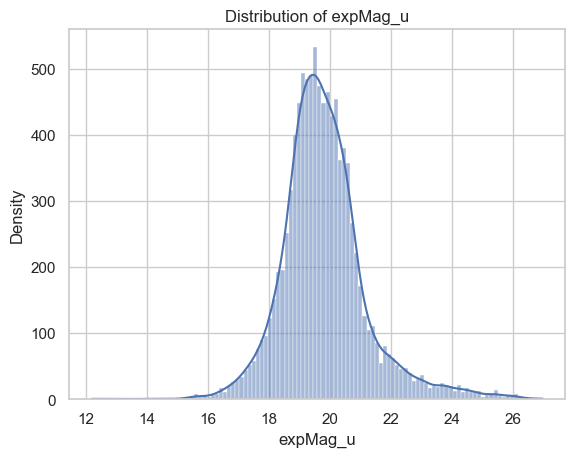

In [132]:
magnitude_cols = ['psfMag_u', 'petroMag_u', 'deVMag_u', 'expMag_u']
for col in magnitude_cols:
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.show()

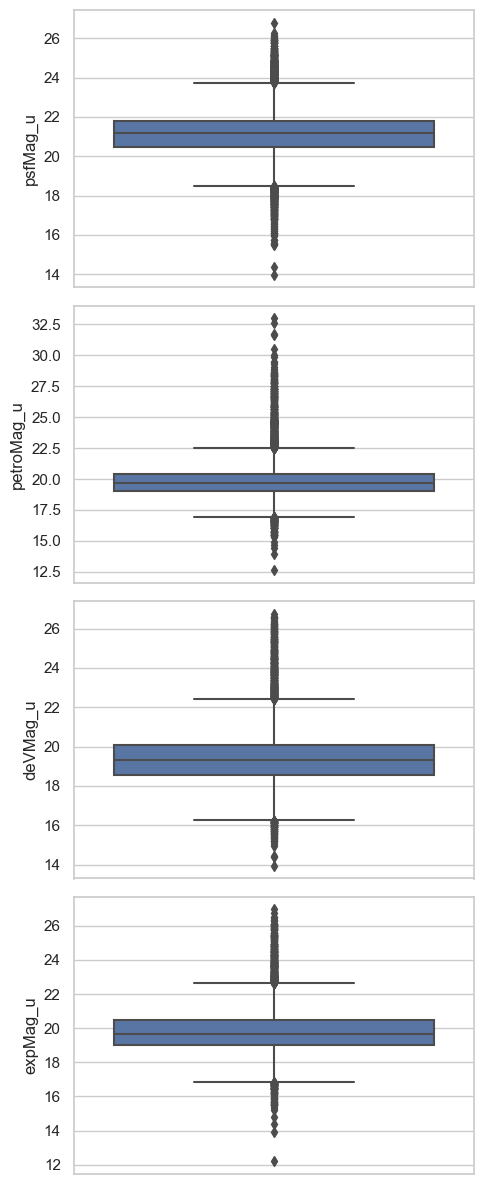

In [134]:
# Specify the columns for which you want to create box plots
columns_to_check = ['psfMag_u', 'petroMag_u', 'deVMag_u', 'expMag_u']

# Create subplots for the box plots
fig, axes = plt.subplots(nrows=len(columns_to_check), ncols=1, figsize=(5, 3 * len(columns_to_check)))

# Loop through each column and create a box plot
for i, col in enumerate(columns_to_check):
    sns.boxplot(data=df, y=col, ax=axes[i])
    axes[i].set_ylabel(col)
    axes[i].set_xlabel(None)  # Remove x-axis label for better spacing
    
# Adjust spacing between subplots
plt.tight_layout()

# Show the box plots
plt.show()

In [147]:
# Specify the columns for which you want to create box plots
columns_to_check = ['psfMag_u', 'petroMag_u', 'deVMag_u', 'expMag_u']

# Create a DataFrame containing the specified columns
boxplot_df = df[columns_to_check]

# Create a box plot using Plotly with the custom blue color palette
fig = px.box(boxplot_df, y=boxplot_df.columns)
fig.update_traces(marker=dict(color='#3ea2b5'))

fig.update_layout(
    title="Box Plots of Magnitude Distributions",
    yaxis_title="Magnitude",
    xaxis_title=None,  # Remove x-axis label for better spacing
)
fig.show()

In [138]:
# List of columns to check for outliers
columns_to_check = ['psfMag_u', 'petroMag_u', 'deVMag_u', 'expMag_u']

# Create a dictionary to store outliers for each column
outliers_dict = {}

# Loop through each column and save outliers in a DataFrame
for col in columns_to_check:
    z_scores = stats.zscore(df[col])
    outliers = (z_scores > 3) | (z_scores < -3)
    outliers_df = df[outliers == True][[col]]
    outliers_dict[col] = outliers_df

# Access the outliers for a specific column like this:
# outliers_df_for_column = outliers_dict['column_name']

# Print or analyze the outliers for each column as needed
for col, outliers_df in outliers_dict.items():
    print(f"Column: {col}, Number of Outliers: {len(outliers_df)}")
    print(outliers_df.head(), '\n')  # Print the first few rows of outliers DataFrame


Column: psfMag_u, Number of Outliers: 81
     psfMag_u
41   26.79023
86   16.32589
353  25.45038
526  15.96273
789  16.83591 

Column: petroMag_u, Number of Outliers: 211
     petroMag_u
23     26.79155
24     28.30484
41     28.21251
75     28.50556
228    27.26637 

Column: deVMag_u, Number of Outliers: 185
     deVMag_u
23   24.90663
41   26.76627
218  24.39826
227  24.20536
228  24.01440 

Column: expMag_u, Number of Outliers: 174
     expMag_u
23   24.90846
41   26.76623
218  24.40184
227  24.15599
228  24.01442 



## Dimensionality reduction

### PCA

Encoding the categorical variables 

In [20]:
# Definitions
label_encoder = LabelEncoder()
df_encoded = df.copy()

# Selecting the categorical variables 
categorical_columns = df.select_dtypes(include=['object']).columns

# Iterate through each categorical column and encode it
for column in categorical_columns:
    df_encoded[column] = label_encoder.fit_transform(df_encoded[column])

Extract the features (independent variables) and standardize the data

In [21]:
# Extract the selected features into X
X = df_encoded.drop('z', axis= 1)

# Standardize the data to have a mean of ~0 and a variance of 1
X = StandardScaler().fit_transform(X)

In [22]:
# Create a PCA instance: pca
pca = PCA()
principal_components = pca.fit_transform(X)

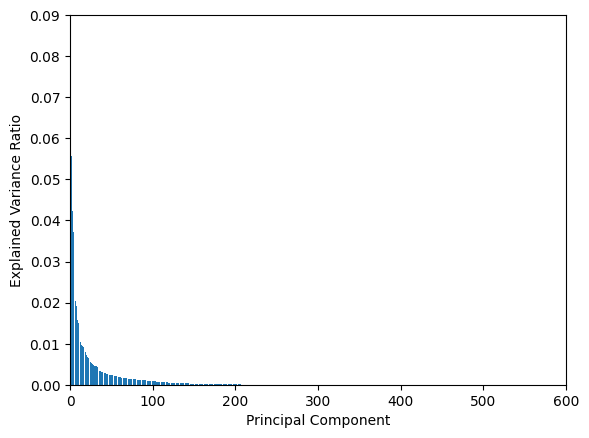

In [23]:
explained_variance_ratio = pca.explained_variance_ratio_
plt.bar(range(len(explained_variance_ratio)), explained_variance_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.ylim(0, 0.09)  # Adjust the y-axis limits here
plt.xlim(0,600)
plt.show()


Performing the PCA

In [24]:
# Fitting the PCA
pca = PCA(100)
pca_transformed = pca.fit_transform(X_norm)
principalDataframe = pd.DataFrame(data = pca_transformed)


NameError: name 'X_norm' is not defined

Visualizing and analyzing the results

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_transformed[:, 0], pca_transformed[:, 1], pca_transformed[:, 2])
plt.show()